# Visualization showing the GISS Global Temperature anomoly distribution over time

This notebook was used to generate the visualizations released as [SVS #4891](https://svs.gsfc.nasa.gov/4981) for the NASA's Scientific Visualization Studio. Designed to be an updated version of an earlier SVS visualization from 2012: [SVS #3975](https://svs.gsfc.nasa.gov/3975)

The visualization illustrated how the distributions of temperatures has changed over time. We use a Kernal Density Estimator(KDE) to estimate the distribution.

[Mark SubbaRao](https://science.gsfc.nasa.gov/sed/bio/mark.u.subbarao)

In [1]:
#imports
import netCDF4 as nc
import numpy as np
from scipy.stats.kde import gaussian_kde
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt
import gzip
import requests

### Data Acquisition
The Data will be imported from the Goddard Institute of Space Studies here: https://data.giss.nasa.gov/gistemp/

Gridded Monthly Temperature Anomaly Data
Users interested in the entire gridded surface air temperature anomaly data may download netCDF files containing selected series on a regular 2°×2° grid or the basic SBBX binary files.

Compressed NetCDF Files (regular 2°×2° grid)
Surface air temperature (no ocean data), 250km smoothing (9 MB)

In [2]:
# Download the gzipped datafile from GISS and load it into a netCDF Dataset
GISTEMPfile = requests.get('https://data.giss.nasa.gov/pub/gistemp/gistemp250_GHCNv4.nc.gz')
ds = nc.Dataset("dummy_path", mode="r", memory=gzip.decompress(GISTEMPfile.content))
v = ds.variables['tempanomaly']

### Save This image to disk!
#### We will use it to as the colormap for the visualizations
We will be using the embedded image below as our colormap. Same this image to disk as as ***gistemp_cmap.png***




In [6]:
# Make the colormap from the saved image
from matplotlib.image import imread
from matplotlib.colors import LinearSegmentedColormap

img = imread('gistemp_cmap.png')
# just pick one column for the colormap
colors_from_img = img[3, :, :]
giss_cmap = LinearSegmentedColormap.from_list('giss_cmap', colors_from_img, N=254)

## Make the Animated Graph

The animated graph will morph between the calculated temperature anomaly distributions for each year. The distribution will be filled under the curve using the color map we created above. A

In [27]:
# This code calculates the distributions that will be used to make the animation
# 
tOffset = 71 # The number of years to skip since the data started in 1880, a value of 71 starts us in 1951
timeStep = 1 # The step between calculated distributions in years
timeBins= 1 # The amount of data to bin in years, usually the same as timeStep
plotRange = (-5.,5.) # The range, in degrees Celcius, over which the PDFs will be calculates
PDFs=[]
startDates=[]
def makePDFs():
    nTimeSteps = int ((v.shape[0] - 12 * tOffset) /(12 * timeStep))
    # The 2x2 degree patches civer different areas, here we create the weights to account for that
    lats = ds.variables['lat'][:].data
    lat_weights = np.broadcast_to(np.cos(np.deg2rad(lats)).reshape(1,-1,1), v.shape)
    masked_lat_weights = np.ma.array(data=lat_weights, mask=v[:].mask)
    for i in range(nTimeSteps):
        xx = np.linspace(plotRange[0],plotRange[1], 2048)
        indexMin = 12*(i*timeStep+tOffset)
        indexMax = 12*(i*timeStep+timeBins+tOffset)
        pdf = gaussian_kde(v[indexMin:indexMax,:,:].compressed(),
                           weights=masked_lat_weights[indexMin:indexMax,:,:].compressed())
        PDFs.append(pdf(xx))
        startDates.append(1880 + indexMin/12.)
    PDFs.append(pdf(xx)) #One extra to hold last position
    startDates.append(1880 + indexMin/12.)
makePDFs()

In [28]:
# Set the resolution for the outputs
resolutionDict = {"HD": 120, "4k": 240, "8k": 480, "print": 64, "thm": 20}
resKey = '4k'
# Find largest distribution value
np.max(PDFs)

0.5886334548557401

In [29]:
def GISSfig(plotTime, startDates, PDFs, timeStep=1., ymax = 0.6):
    from matplotlib.ticker import StrMethodFormatter
    plt.style.use('dark_background')
    fig= plt.figure (figsize=(16,9), dpi = resolutionDict[resKey])
    f,ax=plt.subplots(figsize=(16,9), dpi = resolutionDict[resKey])
    nPlot = int((plotTime-startDates[0])/timeStep)
    interpFrac = (plotTime-startDates[0])%timeStep
    plot=PDFs[nPlot]*(1-interpFrac) + interpFrac*PDFs[nPlot+1]
    res = giss_cmap((xx+2.)/4.) #This colormap is applied from -2 to 2 degrees in SVS visualizations
    for j in range(len(xx)-1):
        plt.fill_between(xx[j:j+2], np.zeros(2), plot[j:j+2], zorder=2, color=res[j])
    plt.plot(xx,plot,color='w',zorder=4)
    plt.plot(xx,PDFs[0],color="grey",zorder=3)
    plt.ylim(0,ymax)
    plt.xlim(-5,5)
    plt.yticks(ticks=None)
    ax.yaxis.set_visible(False)
    plt.grid(True)
    plt.title("Land Temperature Anomaly Distribution",fontsize=32)
    plt.text(.80, 0.85 , f'{int(plotTime)}', fontsize=24,horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    plt.xlabel(u'Temperature Anomaly (°C)', fontsize=14)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)


In [ ]:
# Set up the frames for the animation and save the figure
nStartHold = 1 # Use a value larger than one to hold on the last frame
nEndHold = 1 # Use a value larger than one to hold on the last frame in the animation
nAnimationFrames = 1560 # Number of frames in the animation excluding holds
nRepeat = np.ones(nAnimationFrames)
nRepeat[0] = nStartHold
nRepeat[-1] = nEndHold
figTimes = np.linspace(1951, 2020.9, nAnimationFrames)
nFrame = 0
for i, time in enumerate(figTimes):
    GISSfig(time, startDates, PDFs)
    for n in range(int(nRepeat[i])):
        plt.savefig("GISSTempDist_4k_%03d.png" % (nFrame), dpi = resolutionDict[resKey])
        plt.close()
        nFrame = nFrame + 1

In [ ]:
#Exporting stills of the lastframe
GISSfig(2020.0, startDates, curve, normalize=False)
plt.savefig("GISTempDist_STILL.jpg" , dpi=resolutionDict['8k'])
plt.savefig("GISTempDist_print.jpg", dpi=resolutionDict['print'])
plt.savefig("GISTempDist_thm.png", dpi=resolutionDict['thm'])


## Creation of the RidePlot

A ridgeplot allows us to see the change over time in a single figure. Here we bin in 10 year increments to make a comfortble plot. The code to create this is adapted from The Glowing Python blog: https://glowingpython.blogspot.com/2020/03/ridgeline-plots-in-pure-matplotlib.html.

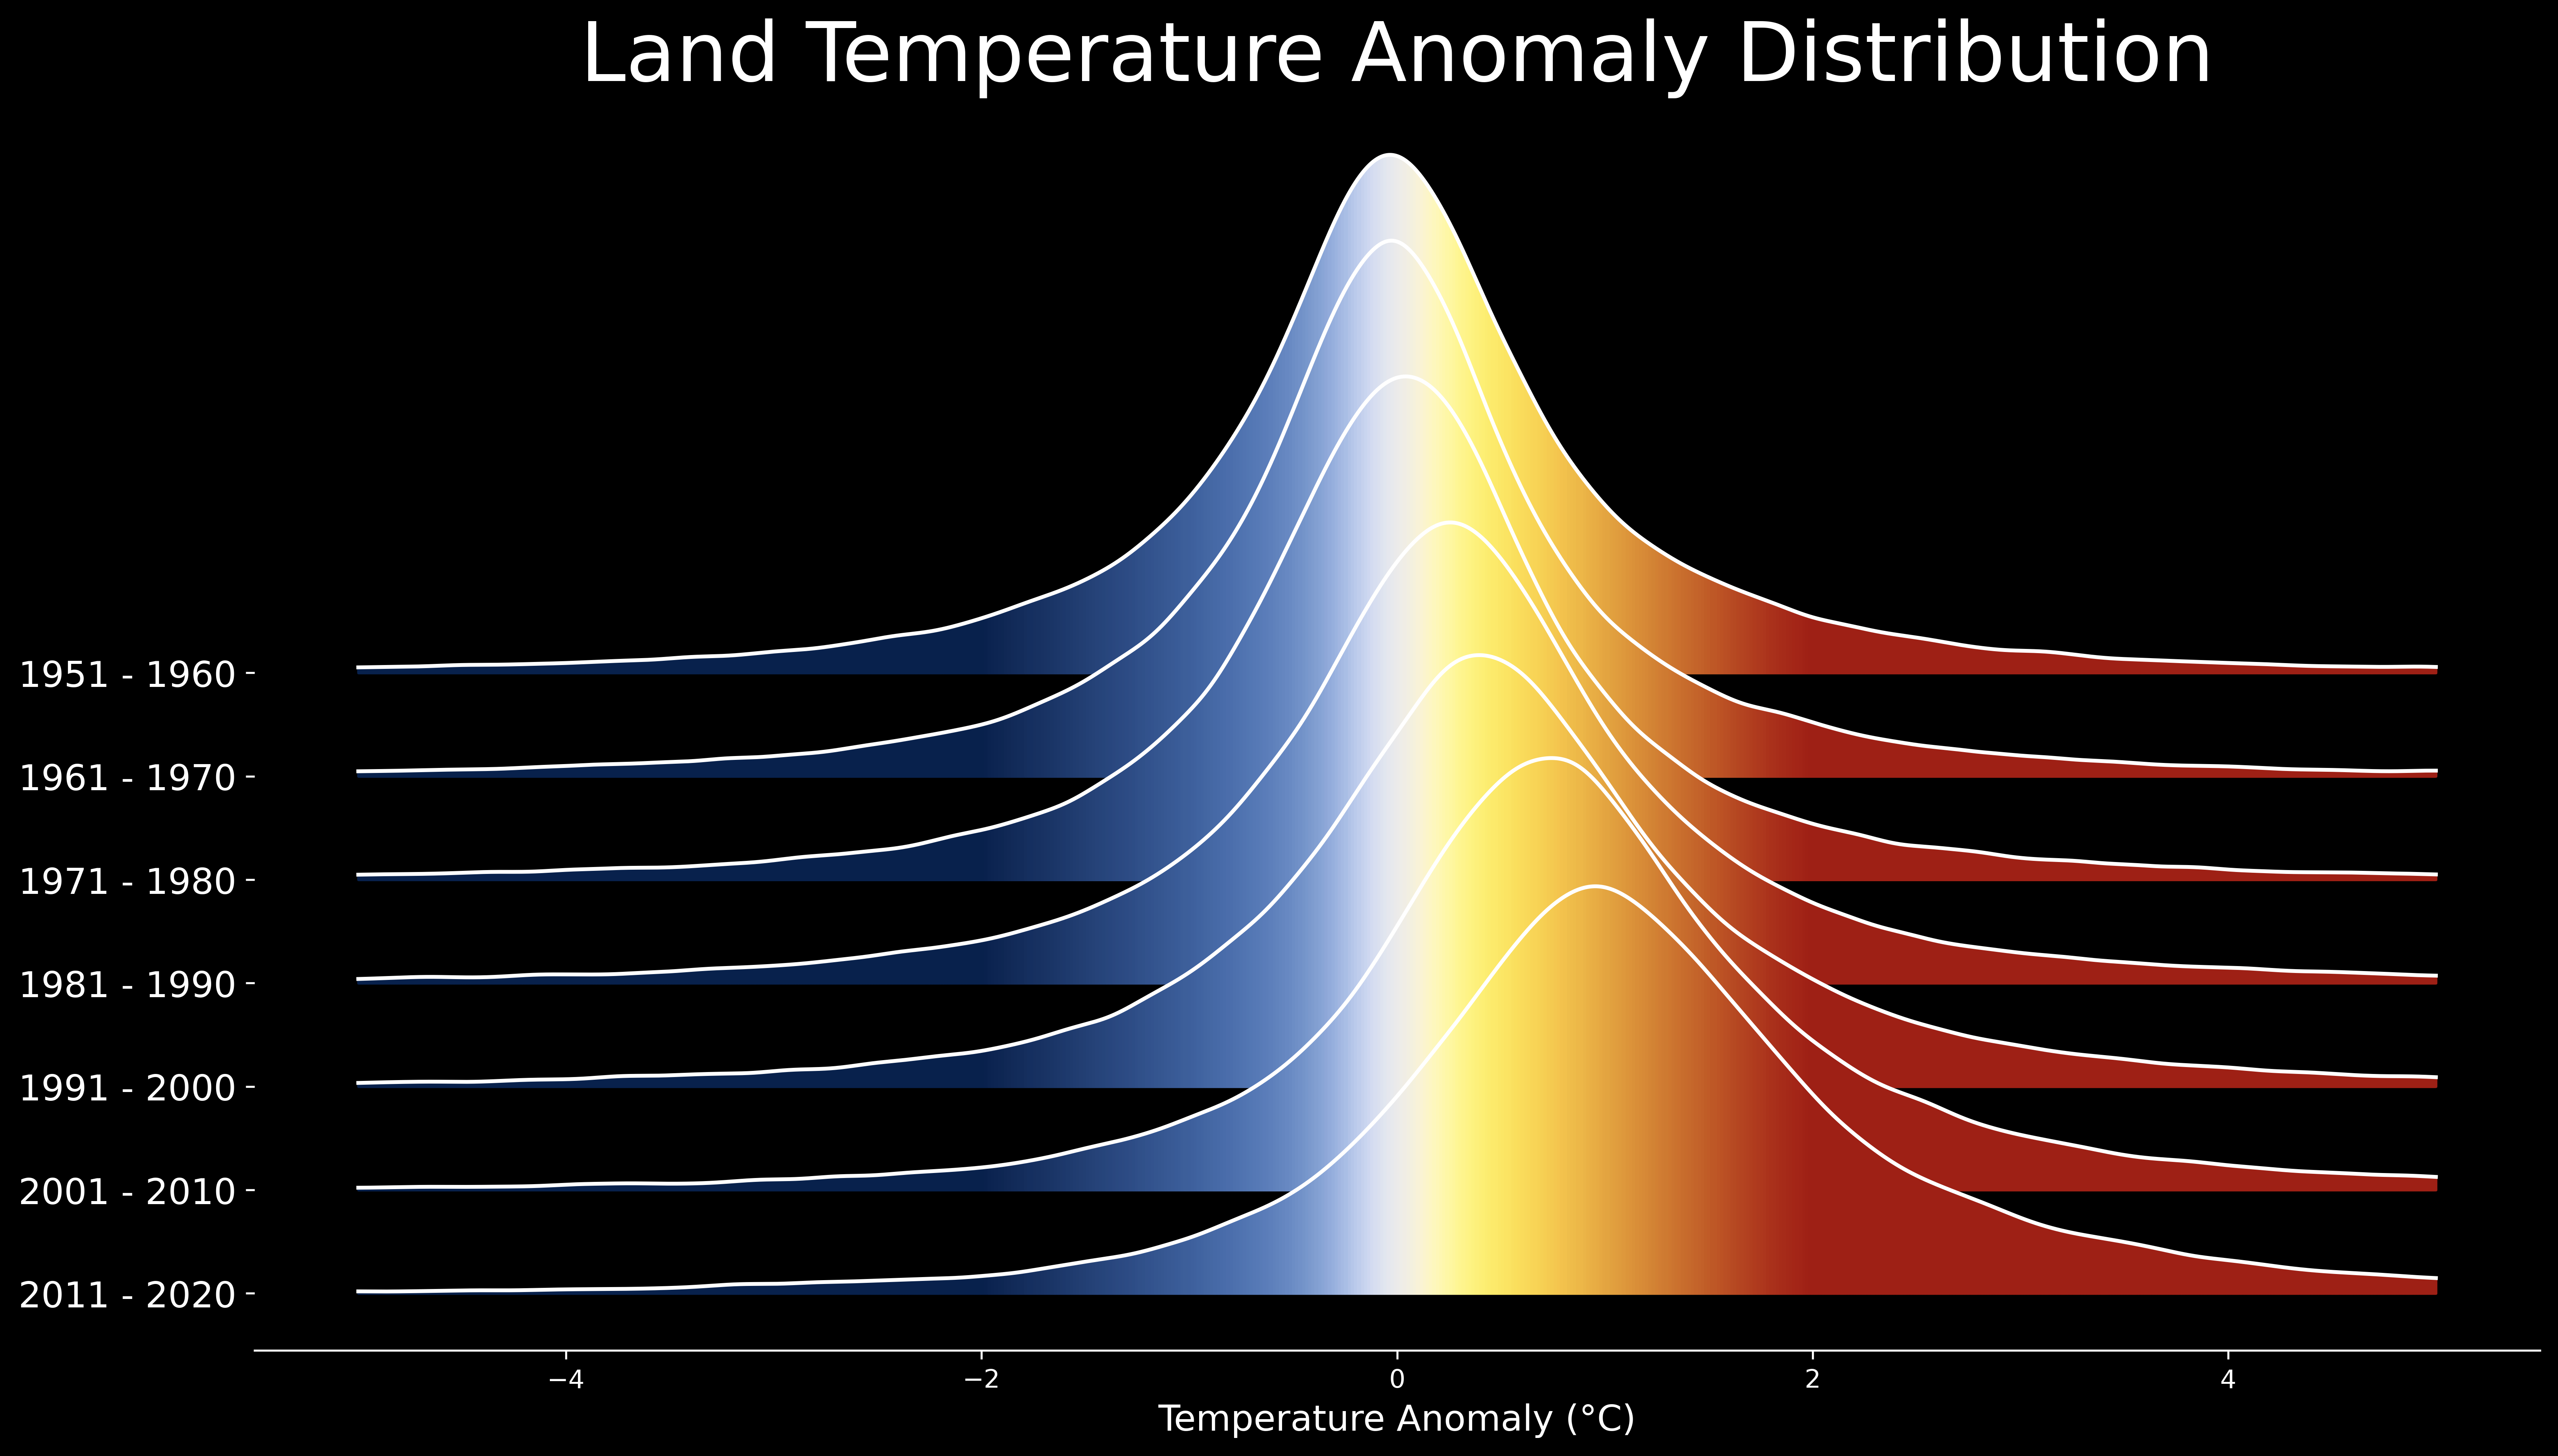

In [34]:
tOffset = 71 # The number of years to skip since the data started in 1880, a value of 71 starts us in 1951
timeStep = 10 # The step between calculated distributions in years
timeBins= 10 # The amount of data to bin in years, usually the same as timeStep
plotRange = (-5.,5.) # The range, in degrees Celcius, over which the PDFs will be calculates
PDFs=[]
startDates=[]
makePDFs()
fig = plt.figure (figsize=(16,9), dpi=resolutionDict['8k'])
nSkip =30 # Amount to skip from the top of the graph (in years)
overlap = 0.9
ys=[]
labels = []
for i in range(7):
    res = giss_cmap((xx+2.)/4.)
    y = 1. - (i-nSkip)*(1.0-overlap)
    ys.append(y)
    for j in range(len(xx)-1):
        plt.fill_between(xx[j:j+2], np.ones(2)*y, PDFs[i][j:j+2]+y, zorder=i+1, color=res[j])
    plt.plot(xx, PDFs[i]+y, c='w', zorder=i+1)
    labels.append(f'{1880 + tOffset + i*timeBins} - {1880 + tOffset + (i+1)*timeBins - 1}')
plt.title("Land Temperature Anomaly Distribution",fontsize=32)
plt.xlabel(u'Temperature Anomaly (°C)', fontsize=14)

plt.yticks(ys, labels, fontsize=14)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)


In [ ]:
fig.set_size_inches(16,9)
fig.savefig("GISSTempRidgeline_STILL.png" ,  dpi=resolutionDict['8k'])
fig.savefig("GISSTempRidgeline_2160.png" , dpi=resolutionDict['4k'])
fig.savefig("GISSTempRidgeline_1080.png" , dpi=resolutionDict['HD'])
fig.savefig("GISSTempRidgeline_print.jpg", dpi=resolutionDict['print'])
fig.savefig("GISSTempRidgeline_thm.png", dpi=resolutionDict['thm'])
